# Imports

In [113]:
#uncomment if connected to colab instance instead of local instance
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install Ipython --upgrade 
# !pip install pyyaml h5py 
import sys 

In [114]:
%load_ext autoreload
%autoreload 2
sys.path.insert(1, "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
import scipy.io
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date       
import tensorflow as tf
from datetime import date
import time
from ESS_utils_HA import *
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

# NY ZONES

## Prep Work

In [610]:
# DATA IMPORTS
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\NY_data\\"
RTP_NYC = np.array(scipy.io.loadmat(dir + "RTP_NYC_2010_2019.mat")['RTP'])
DAP_NYC = np.array(scipy.io.loadmat(dir + "DAP_NYC_2010_2019.mat")['DAP'])
RTP_LONGIL = np.array(scipy.io.loadmat(dir + "RTP_LONGIL_2010_2019.mat")['RTP'])
DAP_LONGIL = np.array(scipy.io.loadmat(dir + "DAP_LONGIL_2010_2019.mat")['DAP'])
RTP_NORTH = np.array(scipy.io.loadmat(dir + "RTP_NORTH_2010_2019.mat")['RTP'])
DAP_NORTH = np.array(scipy.io.loadmat(dir + "DAP_NORTH_2010_2019.mat")['DAP'])
RTP_WEST = np.array(scipy.io.loadmat(dir + "RTP_WEST_2010_2019.mat")['RTP'])
DAP_WEST = np.array(scipy.io.loadmat(dir + "DAP_WEST_2010_2019.mat")['DAP'])
  
RTP = RTP_NYC
DAP = DAP_NYC

### SET PARAMS HERE

In [711]:
#Generating GT Value Functions
'''
Select dates: The data ends on 2019/12/31. We take the data range 2017/1/1 to 2018/12/31
'''

Ts = 1/12 # time step: 5min

# Last day for New England
lastDay = date.toordinal(date(2019, 12, 31)) + 366 - 1 # 737789


start = date.toordinal(date(2017, 1, 1)) + 366 - 1 # 73669
stop = date.toordinal(date(2018, 12, 31)) + 366 - 1 # 737424
startTest = date.toordinal(date(2019, 1, 1)) + 366 - 1
stopTest = date.toordinal(date(2019, 12, 31)) + 366 - 2
ind1 = (len(RTP_WEST[0])-lastDay+startTest-1)
ind2 = (len(RTP_WEST[0])-lastDay+stopTest+1)
# T = int(((stop-start+1)*24/Ts)) # T: 210240, MATLAB: 210240

# tlambda: real time price over time period t
tlambda = RTP[:, (len(RTP[0])-lastDay+start-2):(len(RTP[0])-lastDay+stop+1)] # (288, 731)
tlambda = tlambda.flatten('F')
# tlambda_DA: day ahead price over time period t
tlambda_DA = DAP[:, (len(DAP[0])-lastDay+start-2):(len(DAP[0])-lastDay+stop+1)] # (288, 731)
print(len(DAP[0])-lastDay+start-2)
print(len(DAP[0])-lastDay+stop+1)
print(tlambda_DA.shape)
tlambda_DA = tlambda_DA.flatten('F') # (210528,)
T_CNN = 104820 - 288

'''
Set parameters
'''
Pr = 1/2 # normalized power rating wrt energy rating (highest power input allowed to flow through particular equipment)
P = Pr*Ts  # actual power rating taking time step size into account, 0.5*1/12 = 0.041666666666666664
eta = .9  # efficiency
c = 10  # marginal discharge cost - degradation
ed = 0.001  # SoC sample granularity
ef = .5  # final SoC target level, use 0 if none (ensure that electric vehicles are sufficiently charged at the end of the period)
Ne = math.floor(1/ed)+1  # number of SOC samples, (1/0.001)+1=1001
e0 = .5  # Beginning SoC level


'''
Downsample settings
'''
num_segment = 25

2556
3288
(288, 732)


In [675]:
#for later evaluation
rtp_NYC = RTP_NYC[:, ind1:ind2].flatten('F')
rtp_LONGIL = RTP_LONGIL[:, ind1:ind2].flatten('F')
rtp_NORTH = RTP_NORTH[:, ind1:ind2].flatten('F')
rtp_WEST = RTP_WEST[:, ind1:ind2].flatten('F')

### Hourly Valuation

In [667]:
rtpH_NYC = hr_rebin_1(RTP_NYC[:, ind1:ind2], Ts)
rtpH_LONGIL = hr_rebin_1(RTP_LONGIL[:, ind1:ind2], Ts)
rtpH_NORTH = hr_rebin_1(RTP_NORTH[:, ind1:ind2], Ts)
rtpH_WEST = hr_rebin_1(RTP_WEST[:, ind1:ind2], Ts)

In [668]:
rtpH_NYC = rtpH_NYC.flatten('F')
rtpH_LONGIL = rtpH_LONGIL.flatten('F')
rtpH_NORTH = rtpH_NORTH.flatten('F')
rtpH_WEST = rtpH_WEST.flatten('F')

In [676]:
T = int(rtpH_NYC.shape[0] - 24)

In [677]:
vH_NYC = generate_value_function(1, (P/Ts), eta, c, ed, ef, Ne, T, num_segment, rtpH_NYC)[1]
vH_LONGIL = generate_value_function(1, (P/Ts), eta, c, ed, ef, Ne, T, num_segment, rtpH_LONGIL)[1]
vH_NORTH = generate_value_function(1, (P/Ts), eta, c, ed, ef, Ne, T, num_segment, rtpH_NORTH)[1]
vH_WEST = generate_value_function(1, (P/Ts), eta, c, ed, ef, Ne, T, num_segment, rtpH_WEST)[1]

Time: 1.3240904808044434


### 5 Min Valuation

In [324]:
#GENERATING GT VALUE FUNCTION FOR TRAINING
vAvg = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, num_segment, tlambda)[1]

In [710]:
T = rtp_NYC.shape[0] - 288

In [706]:
#generating test value functions to calculate benchmark profits 5 min valuation
vAvg_NYC = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, num_segment, rtp_NYC)[1]
vAvg_LONGIL = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, num_segment, rtp_LONGIL)[1]
vAvg_NORTH = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, num_segment, rtp_NORTH)[1]
vAvg_WEST = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, num_segment, rtp_WEST)[1]

### Plotting Raw Profits

In [714]:
num = [1000, 500, 250, 100, 50, 25, 10, 5, 1]
Pr = [1/2, 1/4, 1/12, 1/72]
profits = np.zeros((int(len(num)*len(Pr)),))
i = 0
for p in Pr:
  for n in num:
    P = p*Ts
    vAvg_WEST = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, n, rtp_WEST)[1]
    print('\n' + str(int(1/p)) + 'hr WEST OPTIMAL ' + str(n) + ' :')
    profits[i] = evaluate_using_v(rtp_WEST[12:], vAvg_WEST[:, 12:], 
                    eta, c, T_CNN,
                    Ts, p)
    i += 1

Time: 14.497054100036621

2hr WEST OPTIMAL 1000 :
24668
29787
512
Time: 7.36530876159668
Time: 14.625797033309937

2hr WEST OPTIMAL 500 :
24659
29779
512
Time: 6.454466819763184
Time: 14.650508403778076

2hr WEST OPTIMAL 250 :
24599
29739
514
Time: 5.969510793685913
Time: 14.666353464126587

2hr WEST OPTIMAL 100 :
24433
29621
519
Time: 5.432790756225586
Time: 14.668541431427002

2hr WEST OPTIMAL 50 :
24262
29474
521
Time: 5.355211973190308
Time: 14.655295848846436

2hr WEST OPTIMAL 25 :
24030
29231
520
Time: 5.310203790664673
Time: 14.68632984161377

2hr WEST OPTIMAL 10 :
21888
27715
583
Time: 5.348241567611694
Time: 14.610820770263672

2hr WEST OPTIMAL 5 :
20261
26124
586
Time: 5.284900903701782
Time: 14.600810766220093

2hr WEST OPTIMAL 1 :
22622
27114
449
Time: 4.202832460403442
Time: 14.641364336013794

4hr WEST OPTIMAL 1000 :
13808
16858
305
Time: 7.4991724491119385
Time: 14.607354879379272

4hr WEST OPTIMAL 500 :
13779
16841
306
Time: 6.553709506988525
Time: 14.657555103302002

4

In [722]:
prf = profits.reshape((int(len(Pr)), int(len(num))))
prfmax = prf[:, 0]

prfrat = np.zeros_like(prf)
for i, curr in enumerate(prfmax):
  prfrat[i, :] = prf[i, :]/curr
print(prfrat)

[[1.         0.99962591 0.99717546 0.99044757 0.98353598 0.97413301
  0.88729927 0.82134207 0.91706893]
 [1.         0.99792255 0.99360049 0.98563964 0.97769499 0.9305496
  0.86022532 0.79197733 0.91930756]
 [1.         0.99259779 0.9782089  0.94981493 0.91888064 0.87400827
  0.81016298 0.75106798 0.93015616]
 [1.         0.9629603  0.91474343 0.85274379 0.80188471 0.75014084
  0.70887816 0.68163955 0.86630522]]


In [731]:
print(num[:-1])

[1000, 500, 250, 100, 50, 25, 10, 5]


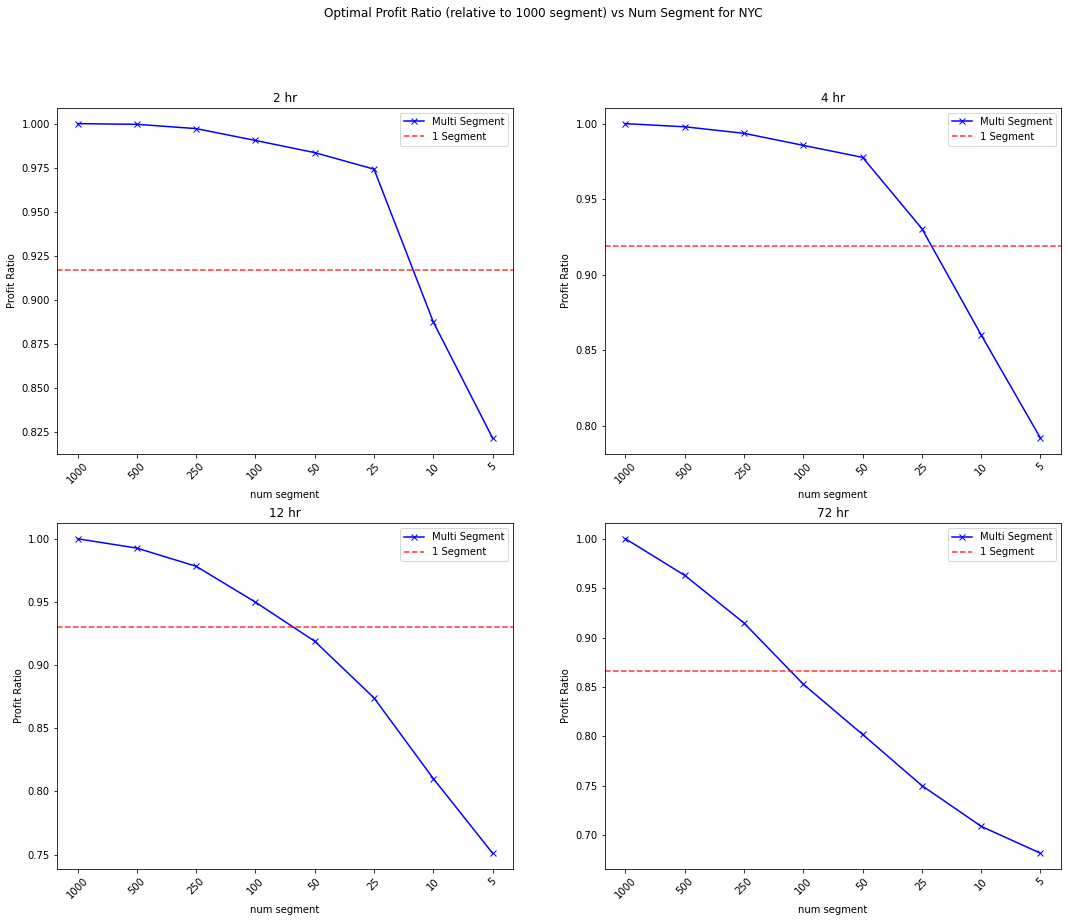

In [780]:
fig, axs = plt.subplots(2, 2)
x = [1,2,3,4,5,6,7,8]
axs[0, 0].plot(x, prfrat[0, :-1], marker='x', color='b', label='Multiseg')
axs[0 ,0].axhline(y=prfrat[0,-1], color='r', linestyle='--', label='1Seg', alpha=0.8)
axs[0, 0].set_title(str(int(Pr[0]**-1)) + ' hr')
axs[0, 1].plot(x, prfrat[1, :-1],  marker='x', color='b', label='Multiseg')
axs[0 ,1].axhline(y=prfrat[1,-1], color='r', linestyle='--', label='1Seg',alpha=0.8)
axs[0, 1].set_title(str(int(Pr[1]**-1)) + ' hr')
axs[1, 0].plot(x, prfrat[2, :-1],  marker='x', color='b', label='Multiseg')
axs[1 ,0].axhline(y=prfrat[2,-1], color='r', linestyle='--', label='1Seg',alpha=0.8)
axs[1, 0].set_title(str(int(Pr[2]**-1)) + ' hr')
axs[1, 1].plot(x, prfrat[3, :-1],  marker='x', color='b', label='Multiseg')
axs[1 ,1].axhline(y=prfrat[3,-1], color='r', linestyle='--', label='1Seg',alpha=0.8)
axs[1, 1].set_title(str(int(Pr[3]**-1)) + ' hr')
fig.suptitle('Optimal Profit Ratio (relative to 1000 segment) vs Num Segment for NYC')
fig.set_size_inches(18, 14)
fig.savefig('C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\rawprof.png', dpi=240)
for ax in axs.flat:
    ax.set(xlabel='num segment', ylabel='Profit Ratio')
    # ax.set_xscale('symlog')
    ax.set_xticks(x, num[:-1], rotation=45)
    ax.legend(['Multi Segment', '1 Segment'])
    # ax.invert_xaxis()


# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

## Training

### RTP + DAP

In [661]:
#Training + Parameter Control
num_DAP = 24
num_RTP = 36
#setting test dir info

#for github users, set folder to the directory 
#where the zip file is extracted
folder = 'C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\'

region = 'NY'
test = 'CNN_LSTM_' + str(num_segment) +'_12hr_HA'
net = 't1' #set string as t1 or vanilla based on which model you want


#uncomment below to generate training set 
# X, y = generate_train_CNN(T, DAP, tlambda, 
#                           start, stop, lastDay, 
#                           num_DAP, num_RTP, vAvg)
# X = np.asarray(X)
# y = np.asarray(y)
# x_train, x_val, y_train, y_val = train_test_split(X, y, 
#                                                   test_size=0.05, shuffle=True)

model = val_CNN_LSTM(output_size=num_segment, net=net)
# model.summary()

In [ ]:
curr_run = net + '_best_model_epoch{epoch:02d}_loss{val_loss:.5f}.hdf5'
checkpoint_path = folder + region + '_tests\\' + test + '\\' + curr_run

#uncomment for early stopping callback
# es_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001,
#     patience=10,
#     verbose=0,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=False
# )


epochs = 100
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', verbose=1, 
                                                 save_best_only=True, mode='min')

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs,batch_size=32, 
                    verbose=1, shuffle =True,
                    callbacks=[cp_callback])

In [ ]:
#training plots
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])

### RTP ONLY (for QNSLND Transfer Learning)


In [ ]:
#Training + Parameter Control

num_RTP=60
X, y = generate_train_CNN_RTP(T, tlambda, 
                              start, stop, lastDay,
                              num_RTP, vAvg)
X = np.asarray(X)
y = np.asarray(y)

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.05, 
                                                  shuffle=True)
model = val_CNN_LSTM(output_size=num_segment, t1=True)
model.summary()

#setting test dir info
folder = 'C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\'
region = 'NY'
test = 'CNN_LSTM_' + str(num_segment) +'_12hr_HA_RTP'

In [ ]:
#loading weights of best previously trained model
model_name = 't1_best_model_epoch70_loss72.03975.hdf5'
dir = folder + zone + '_tests\\' + test + '\\' + model_name
model.load_weights(dir)

In [ ]:
curr_run = 't1_best_model_epoch{epoch:02d}_loss{val_loss:.5f}.hdf5'
checkpoint_path = folder + region + '_tests\\' + test + '\\' + curr_run

#uncomment for early stopping callback
# es_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001,
#     patience=10,
#     verbose=0,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=False
# )


epochs = 100
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', verbose=1, 
                                                 save_best_only=True, mode='min')

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs,batch_size=32, 
                    verbose=1, shuffle =True,
                    callbacks=[cp_callback])

## Evaluation 5 min valuation 5 min Arbitrage



In [662]:
#loading weights of best previously trained model
#set up model in RTP+DAP tab under training
model_name = net + '_best.hdf5'
dir = folder + region + '_tests\\' + test + '\\' + model_name
model.load_weights(dir)

In [663]:
# CNNLSTM evaluate function automatically extracts unseen test data from
# full data vector
# need to run this to extract 5 min value prediction for later downsampling
# and hour prediction
print('NYC PREDICTED:')
v1_NYC, arb1_NY, _ = CNNLSTM_evaluate(model, DAP_NYC, RTP_NYC, 
                                    startTest, stopTest, lastDay,
                                    num_DAP, num_RTP, Pr=Pr)
print('\nLONGIL PREDICTED:')
v1_LONGIL, arb1_LONGIL, _  = CNNLSTM_evaluate(model, DAP_LONGIL, RTP_LONGIL, 
                                          startTest, stopTest, lastDay, 
                                          num_DAP, num_RTP, Pr=Pr)
print('\nNORTH PREDICTED:')
v1_NORTH, arb1_NORTH, _ = CNNLSTM_evaluate(model, DAP_NORTH, RTP_NORTH, 
                                        startTest, stopTest, lastDay, 
                                        num_DAP, num_RTP, Pr=Pr)
print('\nWEST PREDICTED:')
v1_WEST, arb1_WEST, _ = CNNLSTM_evaluate(model, DAP_WEST, RTP_WEST, 
                                      startTest, stopTest, lastDay, 
                                      num_DAP, num_RTP, Pr=Pr)
#function outputs T_CNN, but to avoid having to run this everytime, T_CNN is
  #also declared in prep work

NYC PREDICTED:
Evaluating using X_test
Profit:  1378
Revenue:  2400
Number of Charges/Discharges:  102
Time: 9.07439661026001

LONGIL PREDICTED:
Evaluating using X_test
Profit:  3473
Revenue:  4819
Number of Charges/Discharges:  135
Time: 6.892884254455566

NORTH PREDICTED:
Evaluating using X_test
Profit:  1151
Revenue:  2378
Number of Charges/Discharges:  123
Time: 6.912351608276367

WEST PREDICTED:
Evaluating using X_test
Profit:  3736
Revenue:  4977
Number of Charges/Discharges:  124
Time: 6.898755311965942


In [695]:
'''
optimal profits to beat, T_CNN is received from CNNLSTM_evaluate function to 
make sure that the optimal and prediction are evaluated for the same time steps
'''
T_CNN = 105408-288*2
print('NYC OPTIMAL:')

evaluate_using_v(rtp_NYC[12:], vAvg_NYC[:, 12:], 
                 eta, c, T_CNN,
                 Ts, Pr)
print('\nLONGIL OPTIMAL:')
evaluate_using_v(rtp_LONGIL[12:], vAvg_LONGIL[:, 12:], 
                 eta, c, T_CNN,
                 Ts, Pr)
print('\nNORTH OPTIMAL:')
evaluate_using_v(rtp_NORTH[12:], vAvg_NORTH[:, 12:], 
                 eta, c, T_CNN,
                 Ts, Pr)
print('\nWEST OPTIMAL:')
evaluate_using_v(rtp_WEST[12:], vAvg_WEST[:, 12:], 
                 eta, c, T_CNN,
                 Ts, Pr)


WEST OPTIMAL:
4915
6225
131
Time: 5.614814758300781


1

## Evaluation 1hr valuation 5 min Arbitrage


In [664]:
#need to downsample network predictions to compare to optimal, run CNNLSTM_evaluate
#cell above before this
v1H_NYC = hr_rebin(v1_NYC, Ts)
v1H_LONGIL = hr_rebin(v1_LONGIL, Ts)
v1H_NORTH = hr_rebin(v1_NORTH, Ts)
v1H_WEST = hr_rebin(v1_WEST, Ts)
#these functions include internal hourly arbitrage
print('NYC PREDICTED:')
evaluate_using_v_hr(rtp_NYC[12:], v1H_NYC, eta, c, T_CNN,
         e0, Pr=Pr, Ts=Ts)
print('LONGIL PREDICTED:')
evaluate_using_v_hr(rtp_LONGIL[12:], v1H_LONGIL, eta, c, T_CNN,
         e0, Pr=Pr, Ts=Ts)
print('NORTH PREDICTED:')
evaluate_using_v_hr(rtp_NORTH[12:], v1H_NORTH, eta, c, T_CNN,
         e0, Pr=Pr, Ts=Ts)
print('WEST PREDICTED')
evaluate_using_v_hr(rtp_WEST[12:], v1H_WEST, eta, c, T_CNN,
         e0, Pr=Pr, Ts=Ts)

NYC PREDICTED:
Profit:  1082
Revenue:  2237
LONGIL PREDICTED:
Profit:  2608
Revenue:  4041
NORTH PREDICTED:
Profit:  1129
Revenue:  2458
WEST PREDICTED
Profit:  3539
Revenue:  4897


1

In [448]:
#these functions include internal hourly arbitrage
print('NYC OPTIMAL:')
evaluate_using_v_hr(rtp_NYC[12:], vH_NYC[:, 1:], eta, c, T_CNN,
         e0, Pr=Pr, Ts=Ts)
print('LONGIL OPTIMAL:')
evaluate_using_v_hr(rtp_LONGIL[12:], vH_LONGIL[:,1:], eta, c, T_CNN,
         e0, Pr=Pr, Ts=Ts)
print('NORTH OPTIMAL:')
evaluate_using_v_hr(rtp_NORTH[12:], vH_NORTH[:,1:], eta, c, T_CNN,
         e0, Pr=Pr, Ts=Ts)
print('WEST OPTIMAL:')
evaluate_using_v_hr(rtp_WEST[12:], vH_WEST[:,1:], eta, c, T_CNN,
         e0, Pr=Pr, Ts=Ts)

NYC OPTIMAL:
Profit:  2588
Revenue:  3335
LONGIL OPTIMAL:
Profit:  4661
Revenue:  5717
NORTH OPTIMAL:
Profit:  2640
Revenue:  3607
WEST OPTIMAL:
Profit:  4636
Revenue:  5698


1

# ERCOT: HOUSTON

## Prep Work

In [514]:
# Houston Data 2016/2017 for training
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\TX_data\\2015\\"
RTP_H = pd.read_csv(dir + 'RTP.csv')
DAP_H = pd.read_csv(dir + 'DAP.csv')
RTP_H = np.asarray(RTP_H['Settlement Point Price'])
print(RTP_H.shape)
DAP_H = np.asarray(DAP_H['Settlement Point Price'])
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\TX_data\\2016\\"
RTP_H1 = pd.read_csv(dir + 'RTP.csv')
DAP_H1 = pd.read_csv(dir + 'DAP.csv')
RTP_H1 = np.asarray(RTP_H1['Settlement Point Price'])
DAP_H1 = np.asarray(DAP_H1['Settlement Point Price'])
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\TX_data\\2017\\"
RTP_H2 = pd.read_csv(dir + 'RTP.csv')
DAP_H2 = pd.read_csv(dir + 'DAP.csv')
RTP_H2 = np.asarray(RTP_H2['Settlement Point Price'])
DAP_H2 = np.asarray(DAP_H2['Settlement Point Price'])
# RTP = np.concatenate(( RTP_H1, RTP_H2))
# DAP = np.concatenate((DAP_H1, DAP_H2))
RTP = np.concatenate((RTP_H, RTP_H1, RTP_H2))
DAP = np.concatenate((DAP_H, DAP_H1, DAP_H2))

(35040,)


In [515]:
#Houston Data 2018 for testing
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\TX_data\\2018\\"
RTP_H_test = pd.read_csv(dir + 'RTP.csv')
DAP_H_test = pd.read_csv(dir + 'DAP.csv')
RTP_H_test = np.asarray(RTP_H_test['Settlement Point Price'])
DAP_H_test = np.asarray(DAP_H_test['Settlement Point Price'])

In [606]:
# SETTING PARAMETERS AND PRE-PROCESSING PRICE
#below doesn't apply to houston, but needs to be loaded for later functions to
# work even if not used
# Last day for New England
lastDay = date.toordinal(date(2019, 12, 31)) + 366 - 1 # 737789


start = date.toordinal(date(2017, 1, 1)) + 366 - 1 # 73669
stop = date.toordinal(date(2018, 12, 31)) + 366 - 1 # 737424
startTest = date.toordinal(date(2019, 1, 1)) + 366 - 1
stopTest = date.toordinal(date(2019, 12, 31)) + 366 - 2

'''
Set parameters
'''
Ts = 1/4 # time step: 5min
Pr = 1/12  # normalized power rating wrt energy rating 
P = Pr*Ts  # actual power rating taking time step size into account
eta = .9  # efficiency
c = 10  # marginal cost
ed = .001  # SoC sample granularity
ef = .5  # final SoC target level, use 0 if none
Ne = math.floor(1/ed)+1  # number of SOC samples
e0 = .5  # Beginning SoC level


'''
Downsample settings
'''
num_segment = 1000

In [574]:
print(RTP.shape)
print(RTP_H_test.shape)

(105216,)
(35040,)


In [607]:
#for training
# T = int(len(RTP) - (24/Ts))
# vAvg_H = generate_value_function(Ts, P, eta, c, 
#                                  ed, ef, Ne, T, 
#                                  num_segment, RTP.flatten('F'))[1]
#for generating optimal profit for becnhmarking
Ttest = int(len(RTP_H_test) - (24/Ts))
vAvg_H_test = generate_value_function(Ts, P, eta, c, 
                                 ed, ef, Ne, Ttest, 
                                 num_segment, RTP_H_test.flatten('F'))[1]

Time: 5.162261247634888


In [256]:
print(vAvg_H.shape)
print(vAvg_H_test.shape)

(10, 105121)
(10, 34945)


## Training


In [600]:
#Training + Parameter Control
num_RTP= 20 
num_DAP= 18
#setting test dir info
folder = 'C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\'
region = 'TX'
test = 'CNN_LSTM_' + str(num_segment) +'_12hr_HA'
net = 't1'
# T_H = int(RTP.shape[0]-24/Ts)
# X, y = generate_train_CNN(T_H, DAP, RTP, 
#                           start, stop, lastDay, 
#                           num_DAP, num_RTP, vAvg_H, 
#                           TX=True, Ts=Ts)
# X = np.asarray(X)
# y = np.asarray(y)
# x_train, x_val, y_train, y_val = train_test_split(X, y, 
#                                                   test_size=0.05, shuffle=True)
# #set t1 to true or false depending on whether you want to instantiate t1 
# #or vanilla model
model = val_CNN_LSTM(input_size = (int(num_RTP+num_DAP), int(num_RTP+num_DAP), 1), 
                     output_size=num_segment, net=net, step=int(num_RTP+num_DAP))
# model.summary()

In [ ]:
curr_run = net + '_best_model_epoch{epoch:02d}_loss{val_loss:.5f}.hdf5'
checkpoint_path = folder + region + '_tests\\' + test + '\\' + curr_run

#uncomment for early stopping callback
# es_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001,
#     patience=10,
#     verbose=0,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=False
# )


epochs = 100
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', verbose=1, 
                                                 save_best_only=True, mode='min')

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs,batch_size=32, 
                    verbose=1, shuffle =True,
                    callbacks=[cp_callback])

## Evaluation

In [602]:
#load best model weights
model_name = net + '_best.hdf5'
dir = folder + region + '_tests\\' + test + '\\' + model_name
model.load_weights(dir)

In [603]:
#extracting value function from CNNLSTM_evaluate function
v_H1, _, T_CNN = CNNLSTM_evaluate(model, DAP_H_test, RTP_H_test, 
                                    startTest, stopTest, lastDay, 
                                    num_DAP, num_RTP, TX=True, Pr=Pr, Ts=Ts)

Evaluating using X_test
Profit:  3825
Revenue:  4291
Number of Charges/Discharges:  47
Time: 2.126899242401123


In [608]:
print('HOUSTON OPTIMAL:')
evaluate_using_v(RTP_H_test[4:], vAvg_H_test[:,4:], 
                 eta, c, T_CNN, Ts, Pr=Pr)

HOUSTON OPTIMAL:
5600
6535
93
Time: 2.5001652240753174


1

# QUEENSLAND

## Prep Work

In [630]:
#Queensland Data 2019 for training
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\QNSLND_data\\"
RTP_Q = pd.read_csv(dir + 'RTP_2019.csv')
RTP_Q = np.asarray(RTP_Q['energyPrice'])
RTP_Q = RTP_Q*0.6954 #average exchange rate to USD in 2019

In [631]:
#Queensland Data 2021 for testing
RTP_Q_test = pd.read_csv(dir + 'RTP_2021.csv')
RTP_Q_test = np.asarray(RTP_Q_test['Energy Price ($/MWh)'])
RTP_Q_test = RTP_Q_test*0.7513 #average exchange rate to USD in 2021

In [657]:
# Last day for New England
lastDay = date.toordinal(date(2019, 12, 31)) + 366 - 1 # 737789


start = date.toordinal(date(2017, 1, 1)) + 366 - 1 # 73669
stop = date.toordinal(date(2018, 12, 31)) + 366 - 1 # 737424
startTest = date.toordinal(date(2019, 1, 1)) + 366 - 1
stopTest = date.toordinal(date(2019, 12, 31)) + 366 - 2
'''
Set parameters
'''
Ts = 1/12 # time step: 5min
Pr = 1/12 # normalized power rating wrt energy rating 
P = Pr*Ts  # actual power rating taking time step size into account
eta = .9  # efficiency
c = 10  # marginal cost
ed = .001  # SoC sample granularity
ef = .5  # final SoC target level, use 0 if none
Ne = math.floor(1/ed)+1  # number of SOC samples
e0 = .5  # Beginning SoC level


'''
Downsample settings
'''
num_segment = 50

In [658]:
#for transfer learning
# vAvg_Q = generate_val_eval(RTP_Q,  Pr=Pr, 
#                            num_segment=num_segment, Q=True)[1]
#for generating optimal profit for becnhmarking
Ttest = int(len(RTP_Q_test.flatten('F'))-288)
vAvg_Q_test = generate_value_function(Ts, P, eta, c, 
                                 ed, ef, Ne, Ttest, 
                                 num_segment, RTP_Q_test.flatten('F'))[1]

Time: 5.155590534210205


## Transfer Learning

In [640]:
#Training + Parameter Control
T_Q = 102792 #choosing days for queensland training
num_RTP=60
#setting test dir info
folder = 'C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\'
region = 'QNSLND'
test = 'CNN_LSTM_' + str(num_segment) +'_0.5_HA_RTP'
net = 'vanilla'
# X, y = generate_train_CNN_RTP(T_Q, RTP_Q.flatten('F'), 
#                               start, stop, lastDay, 
#                               num_RTP, vAvg_Q)
# X = np.asarray(X)
# y = np.asarray(y)

# x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.05, 
#                                                   shuffle=True)
model = val_CNN_LSTM(output_size=num_segment, net=net)
# model.summary()



In [ ]:
# Note transfer learning here uses only RTP model from NY zone
model_name = 't1_best_model_epoch76_loss94.32.hdf5'
dir = folder + 'NY_tests\\' + test + '\\' + model_name
#freezing all weights save for last dense layer (-3 bc reshapes after dense)
for layer in model.layers[:-3]:
    layer.trainable = False

In [ ]:
curr_run = net + '_best_model_epoch{epoch:02d}_loss{val_loss:.5f}.hdf5'
checkpoint_path = folder + region + '_tests\\' + test + '\\' + curr_run

#uncomment for early stopping callback
# es_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001,
#     patience=10,
#     verbose=0,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=False
# )


epochs = 40
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', verbose=1, 
                                                 save_best_only=True, mode='min')

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs,batch_size=32, 
                    verbose=1, shuffle =True,
                    callbacks=[cp_callback])

## Evaluation

In [642]:
#load best model weights from transfer learning
model_name = net + '_best.hdf5'
dir = folder + region + '_tests\\' + test + '\\' + model_name
model.load_weights(dir)

In [643]:
print('QUEENSLAND PREDICTED:')
vR_Q, arbR_Q, T_CNN = CNNLSTM_evaluate_RTP(model, RTP_Q_test, 
                                    startTest, stopTest, lastDay, 
                                    num_RTP, Q=True, Pr=Pr)

QUEENSLAND PREDICTED:
Evaluating using X_test
Profit:  13646
Revenue:  14511
Number of Charges/Discharges:  86
Time: 4.815032720565796


In [659]:
num_RTP = 60
print('QUEENSLAND OPTIMAL:')
evaluate_using_v(RTP_Q_test[12:], vAvg_Q_test[:,12:],
                 eta, c, T_CNN, Ts=Ts, Pr=Pr)

QUEENSLAND OPTIMAL:
2987
3377
39
Time: 1.9910001754760742


1

# Test to check agreement between matlab and python valuation/arbitrage


## following exact sequence as laid out in matlab code

In [26]:
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\NY_data\\"
RTP = np.array(scipy.io.loadmat(dir + "RTP_WEST_2010_2019.mat")['RTP'])
DAP = np.array(scipy.io.loadmat(dir + "DAP_WEST_2010_2019.mat")['DAP'])

In [27]:
RTP = RTP[:, ind1:ind2]
DAP = DAP[:, ind1:ind2]

In [28]:
rtpH = hr_rebin_1(RTP, Ts)
dapH = hr_rebin_1(DAP, Ts)

In [29]:
rtpH = rtpH.flatten('F')
dapH = dapH.flatten('F')

In [41]:
    Ts = 1/12
    Pr = 0.5  # normalized power rating wrt energy rating (highest power input allowed to flow through particular equipment)
    P = Pr*Ts  # actual power rating taking time step size into account, 0.5*1/12 = 0.041666666666666664
    eta = 0.9  # efficiency
    c = 10  # marginal discharge cost - degradation
    ed = 0.001  # SoC sample granularity
    ef = .5  # final SoC target level, use 0 if none (ensure that electric vehicles are sufficiently charged at the end of the period)
    Ne = math.floor(1/ed)+1  # number of SOC samples, (1/0.001)+1=1001
    e0 = .5  # Beginning SoC level
    T = int(rtpH.shape[0]-24)

In [31]:
print(rtpH[:24])

[ 6.47583333 12.12416667 12.69333333  3.4825      6.62833333 18.04916667
 11.69083333  0.67083333  2.20416667  1.44416667  9.88166667 10.05416667
 12.77        3.74833333  3.32833333  9.30666667 17.12333333 26.83833333
 49.72416667 76.665      54.325      34.5025     19.0725     10.77666667]


In [ ]:
v, vH = generate_value_function(1, (P/Ts), eta, c, ed, ef, Ne, T, 1, rtpH)

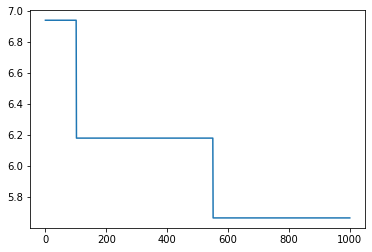

In [43]:
plt.plot(v[:,0])

In [44]:
rtp = RTP.flatten('F')
T = int(rtp.shape[0]-288)

In [35]:
print(rtp[0:12])

[ 6.24  6.27  6.53  8.39 10.63 10.63  7.6   4.75  4.47  3.43  3.91  4.86]


In [36]:
print(vH.shape)

(1, 8737)


In [45]:
  print(v[:, 0])

[6.93888889 6.93888889 6.93888889 ... 5.664      5.664      5.664     ]


In [38]:
eS = np.zeros(T) # generate the SoC series
pS = np.zeros(T) # generate the power series
e = 0.5
m=0
day = int(24/Ts)
for t in range(T):
  vv = vH[:, int(np.floor(m+1))]
  e, p = ArbValue(rtp[t+day], vv, e, P, 1, eta, c, vH.shape[0])
  eS[t] = e
  pS[t] = p
  m+=Ts
ProfitOutTest = np.sum(pS * rtp[day:T+day]) - np.sum(c * pS[pS>0])
RevenueTest = np.sum(pS * rtp[day:T+day])

In [39]:
print("Profit: ", round(ProfitOutTest))
print("Revenue: ", round(RevenueTest))

Profit:  21721
Revenue:  26105


## using evaluate function

In [46]:
evaluate_using_v_hr(rtp, vH, eta, c, T_CNN,
                    e0, Pr=Pr, Ts=Ts)

Profit:  21721
Revenue:  26103


1